## LA's COVID-19 Reopening Indicators 
This report contains information about how LA County and LA City performed, compared to yesterday, on a number of key COVID-19 indicators related to the speed at which opening up can occur. Taken together, performing well against the benchmarks provide confidence in moving through each phase of reopening. 

As long as LA consistently tests large portions of its population with fairly low positive COVID-19 results, sustain decreases in caseloads and deaths, and have ample available hospital equipment for any surge, we are positioned to continue loosening restrictions. When any indicator fails to meet the benchmark, we should slow down our reopening plans and possibly enact more stringent social distancing protocols.     
    
* [Federal Gating Criteria](https://www.whitehouse.gov/wp-content/uploads/2020/04/Guidelines-for-Opening-Up-America-Again.pdf)
* [State Gating Criteria](https://covid19.ca.gov/roadmap-counties/)

Below, you will see how LA is doing compared to yesterday on the follow indicators. 

#### Symptoms
* Downward trajectory of influenza-like illnesses (ILI) reported within a 14-day period **and**
* Downward trajectory of COVID-like syndromic cases reported within a 14-day period

#### Cases
* Downward trajectory of documented cases within a 14-day period **or**
* Downward trajectory of positive tests as a percent of total tests within a 14-day period (flat or increasing volume of tests) 

#### Hospitals
* Treat all patients without crisis care **and**
* Robust testing program in place for at-risk healthcare workers, including emerging antibody testing

### References
* [Reopening Indicators](https://github.com/CityOfLosAngeles/covid19-indicators/blob/master/references/Reopening_Indicators_Comparison.xlsx) from [New York State](https://www.nytimes.com/2020/05/04/nyregion/coronavirus-reopen-cuomo-ny.html) and [Chicago](https://www.chicagotribune.com/coronavirus/ct-coronavirus-chicago-reopening-lightfoot-20200508-ztpnouwexrcvfdfcr2yccbc53a-story.html)
* [Collection of articles](https://github.com/CityOfLosAngeles/covid19-indicators/blob/master/reopening-sources.md) related to what experts say about reopening and the known unknowns ahead 
    * [LA and Chicago](https://www.nytimes.com/2020/05/09/us/coronavirus-chicago.html), after NYC, have the most persistent virus caseloads
    * [LA, DC, and Chicago](https://www.latimes.com/california/story/2020-05-22/white-house-concerned-with-coronavirus-spread-in-l-a-area-asks-cdc-to-investigate) remain hotspots within the US

In [1]:
import numpy as np
import pandas as pd

import utils
import default_parameters
import make_charts
import meet_indicators

from IPython.display import display_html, Markdown 

# Default parameters
county_state_name = default_parameters.county_state_name
state_name = default_parameters.state_name
msa_name = default_parameters.msa_name
time_zone = default_parameters.time_zone

fulldate_format = default_parameters.fulldate_format
monthdate_format = default_parameters.monthdate_format
start_date = default_parameters.start_date
yesterday_date = default_parameters.yesterday_date
today_date = default_parameters.today_date
two_weeks_ago = default_parameters.two_weeks_ago
two_days_ago = default_parameters.two_days_ago

# Daily testing upper and lower bound
county_test_lower_bound = 15_000
county_test_upper_bound = 16_667
city_test_lower_bound = round(county_test_lower_bound * 0.5)
city_test_upper_bound = round(county_test_upper_bound * 0.5)
positive_lower_bound = 0.04
positive_upper_bound = 0.08
hospital_bound = 0.30

In [2]:
def check_report_readiness(county_state_name, state_name, msa_name, start_date, yesterday_date):
    """
    Check if each dataframe has yesterday's date's info.
    If all datasets are complete, report can be run.
    """
    
    df = utils.prep_county(county_state_name, start_date)
    if df.date2.max() < yesterday_date:
        raise Exception("Data incomplete")    
    
    df = utils.prep_lacity_cases(start_date)
    if df.date2.max() < yesterday_date:
        raise Exception("Data incomplete")        
    
    df = utils.prep_testing(start_date)
    if df.date2.max() < yesterday_date:
        raise Exception("Data incomplete")        
    
    df = utils.prep_lacounty_hospital(start_date)
    if df.date2.max() <  yesterday_date:
        raise Exception("Data incomplete") 
        
check_report_readiness(county_state_name, state_name, msa_name, start_date, yesterday_date)

Exception: Data incomplete

In [3]:
# Check cases according to some criterion
def check_cases(row):
    status = ["failed" if x < 14 else "met" if x >= 14 else "" for x in row]
    return pd.Series(status, index=row.index, dtype="category")

def check_deaths(row):
    status = ["failed" if x < 14 else "met" if x >= 14 else "" for x in row]
    return pd.Series(status, index=row.index, dtype="category")

def check_tests(lower_bound, upper_bound, row):
    status = ["failed" if x < lower_bound 
              else "met" if ((x >= lower_bound) and (x < upper_bound)) 
              else "exceeded" if x >= upper_bound 
              else "" for x in row]
    return pd.Series(status, index=row.index, dtype="category")

def check_positives(row):
    status = ["failed" if x > positive_upper_bound 
              else "met" if ((x > positive_lower_bound) and (x <= positive_upper_bound)) 
              else "exceeded" if x >= positive_lower_bound 
              else "" for x in row]
    return pd.Series(status, index=row.index, dtype="category")

def check_hospitals(row):
    status = ["failed" if x < hospital_bound 
              else "met" if x >= hospital_bound 
              else "" for x in row]
    return pd.Series(status, index=row.index, dtype="category")    

county_fnmap = {
    "Cases": check_cases,
    "Deaths": check_deaths,
    "Daily Testing": lambda row: check_tests(county_test_lower_bound, county_test_upper_bound, row),
    "Positive Tests": check_positives,
    "Acute Beds": check_hospitals,
    "ICU Beds": check_hospitals,
    "Ventilators": check_hospitals,
}

city_fnmap = {
    "Cases": check_cases,
    "Deaths": check_deaths,
    "Daily Testing": lambda row: check_tests(city_test_lower_bound, city_test_upper_bound, row),
    "Positive Tests": check_positives,
    "Acute Beds": check_hospitals,
    "ICU Beds": check_hospitals,
    "Ventilators": check_hospitals,
}

red = make_charts.maroon
green = make_charts.green
blue = make_charts.blue

stylemap = {
    "failed": f"background-color: {red}; color: white; font-weight: bold; opacity: 0.6",
    "met": f"background-color: {green}; color: white; font-weight: bold; opacity: 0.6",
    "exceeded": f"background-color: {blue}; color: white; font-weight: bold; opacity: 0.6",
    "": "background-color: white; color: black; font-weight: bold; opacity: 0.6",
}

In [4]:
def summary_of_indicators():
    # Grab indicators
    county_case_indicator = meet_indicators.meet_case("county", county_state_name, start_date)
    county_death_indicator = meet_indicators.meet_death("county", county_state_name, start_date)
    county_test_indicator = meet_indicators.meet_daily_testing(yesterday_date, "county", 
                                                               county_test_lower_bound, county_test_upper_bound)
    county_positive_indicator = meet_indicators.meet_positive_share(yesterday_date, "county", 
                                                                    positive_lower_bound, positive_upper_bound)
    acute_indicator = meet_indicators.meet_acute(yesterday_date)
    icu_indicator = meet_indicators.meet_icu(yesterday_date)
    ventilator_indicator = meet_indicators.meet_ventilator(yesterday_date)


    city_case_indicator = meet_indicators.meet_lacity_case(start_date)
    city_test_indicator = meet_indicators.meet_daily_testing(yesterday_date, "city", 
                                                                   city_test_lower_bound, city_test_upper_bound)
    city_positive_indicator = meet_indicators.meet_positive_share(yesterday_date, "city", 
                                                                  positive_lower_bound, positive_upper_bound)
    
    
    indicator_names = ["Cases", "Deaths", "Daily Testing", "Positive Tests", 
                       "Acute Beds", "ICU Beds", "Ventilators"]
    
    
    # Create separate df for county and city
    county = pd.DataFrame(
        {"LA County": [county_case_indicator, county_death_indicator, 
                    county_test_indicator, county_positive_indicator, 
                    acute_indicator, icu_indicator, ventilator_indicator]},
        index=indicator_names
    )

    city = pd.DataFrame(
        {"City of LA": [city_case_indicator, np.nan, 
                    city_test_indicator, city_positive_indicator, 
                    np.nan, np.nan, np.nan]},
        index=indicator_names
    )

    # Style the table
    def display_side_by_side(*args):
        html_str=''
        for df in args:
            html_str+=df
        display_html(html_str.replace('table','table style="display:inline"'),raw=True)
   
        
    county_html = (county.style
                   .format(lambda s: f"{s:,g}", na_rep="-")
                   .apply(lambda row: county_fnmap[row.name](row).map(stylemap), axis=1)
                   .render()
                  )
    city_html = (city.style
                 .format(lambda s: f"{s:,g}", na_rep="-")
                 .apply(lambda row: city_fnmap[row.name](row).map(stylemap), axis=1)
                 .hide_index()
                 .render()
                )       
        
    # Display summary
    display(Markdown(f"### Summary of Indicators as of {yesterday_date}:"))
    display(Markdown("Cases and deaths report the number of days with declining values over the past 14 days."))
    display(Markdown("These should sustain a 14-day downward trajectory."))
    display(Markdown("Indicators can <bold><span style='color:#F3324C'>fail to meet the lower benchmark; </span><span style='color:#10DE7A'>meet the lower benchmark; </span><span style = 'color:#1696D2'>or exceed the higher benchmark.</span></bold>"))    
    display_side_by_side(county_html, city_html)

In [5]:
summary_of_indicators()

### Summary of Indicators as of 6/7/20:

Cases and deaths report the number of days with declining values over the past 14 days.

These should sustain a 14-day downward trajectory.

Indicators can <bold><span style='color:#F3324C'>fail to meet the lower benchmark; </span><span style='color:#10DE7A'>meet the lower benchmark; </span><span style = 'color:#1696D2'>or exceed the higher benchmark.</span></bold>

LA County 
 
 Cases 
 5 
 
 
 Deaths 
 7 
 
 
 Daily Testing 
 - 
 
 
 Positive Tests 
 0.17 
 
 
 Acute Beds 
 0.19 
 
 
 ICU Beds 
 0.14 
 
 
 Ventilators 
 0.55 
 
 City of LA 
 
 5 
 
 
 - 
 
 
 - 
 
 
 0.26 
 
 
 - 
 
 
 - 
 
 
 -

## Caseload Charts

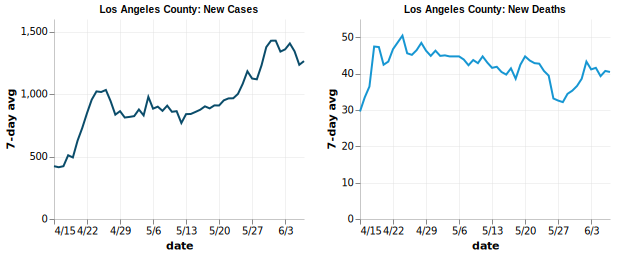

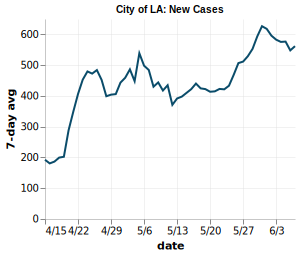

In [6]:
la_county = utils.county_case_charts(county_state_name, start_date)
la_city = utils.lacity_case_charts(start_date) 

## Testing Charts

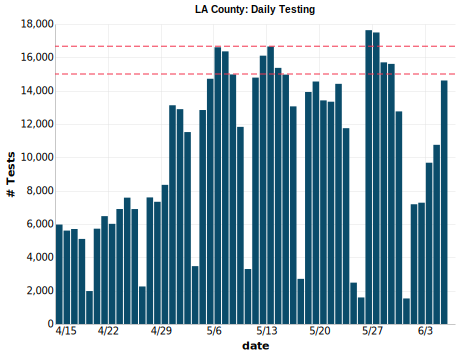

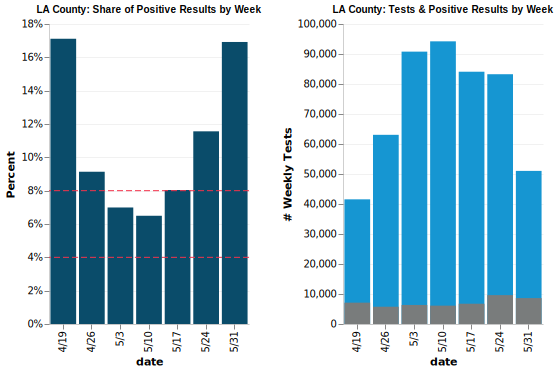

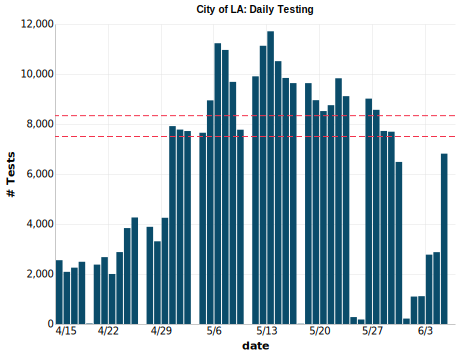

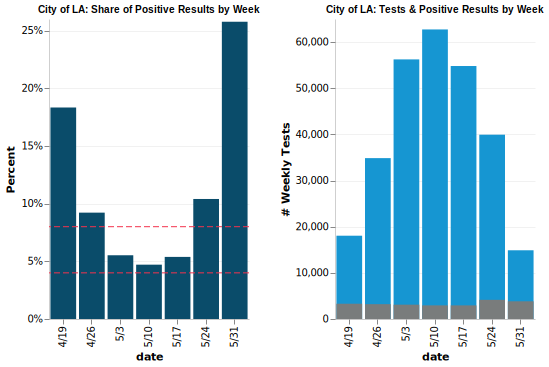

In [7]:
county_tests = utils.lacounty_testing_charts(start_date, county_test_lower_bound, county_test_upper_bound)
positive_tests = utils.lacounty_positive_test_charts(start_date, positive_lower_bound, positive_upper_bound)
city_tests = utils.lacity_testing_charts(start_date, city_test_lower_bound, city_test_upper_bound)
positive_tests = utils.lacity_positive_test_charts(start_date, positive_lower_bound, positive_upper_bound)

## Hospital Capacity Charts

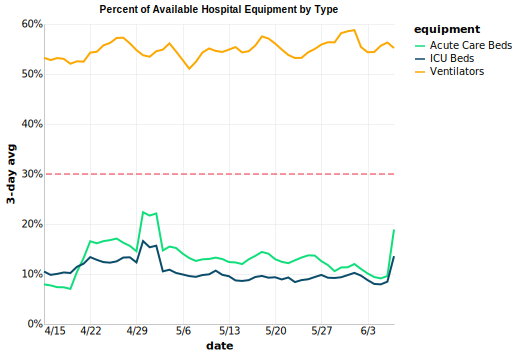

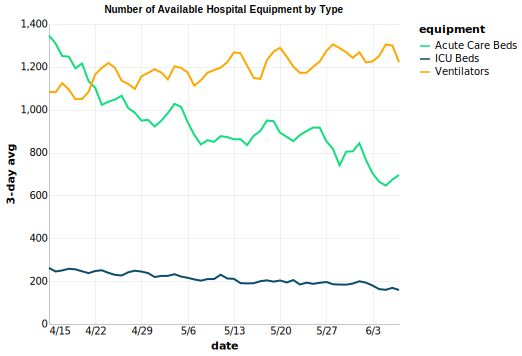

In [8]:
hospital = utils.lacounty_hospital_charts(start_date)

If you have any questions, please email itadata@lacity.org